In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import tqdm 
import numpy as np
from torchmetrics.image import StructuralSimilarityIndexMeasure

print("CUDA:", torch.cuda.is_available())
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

CUDA: False


In [301]:
def angular_spectrum_propagation(U0, wvl, dx, z):
    """
    Propagates an optical field using the Bandlimited Angular Spectrum Method over a range of distances.

    Parameters:
        U0      : 4D torch tensor (batch, channel, x, y)
        wvl     : float (wavelength of light in meters)
        dx      : float (sampling interval in meters)
        z       : float (propagation distance in meters)

    Returns:
        U1  : the propagated field (same shape as U0)
    """
    batch, channel, original_height, original_width = U0.shape
    pad_height, pad_width = original_height // 2, original_width // 2

    z = torch.tensor([z], device=U0.device)
    # Pad input field
    U0_padded = torch.zeros((batch, channel, original_height + 2 * pad_height, original_width + 2 * pad_width), dtype=U0.dtype, device=U0.device)
    U0_padded[:, :, pad_height:pad_height + original_height, pad_width:pad_width + original_width] = U0

    ny, nx = U0_padded.shape[-2:]
    k = 2 * torch.pi / wvl

    # Create spatial frequency coordinates
    fx = torch.fft.fftfreq(nx, dx, device=U0.device)
    fy = torch.fft.fftfreq(ny, dx, device=U0.device)
    FX, FY = torch.meshgrid(fx, fy)  # Ensure FX and FY have last two dimensions
    FX = FX.reshape(1,1, FX.shape[0], FX.shape[1])
    FY = FY.reshape(1,1, FY.shape[0], FY.shape[1])

    Delta_uy = 1 / (ny * dx)
    Delta_ux = 1 / (nx * dx)
    u_limity = 1 / (torch.sqrt((2 * Delta_uy * z) ** 2 + 1) * wvl)
    u_limitx = 1 / (torch.sqrt((2 * Delta_ux * z) ** 2 + 1) * wvl)
    H_limit = ((FY ** 2 / u_limity ** 2 + FX ** 2 * wvl ** 2) < 1) * ((FX ** 2 / u_limitx ** 2 + FY ** 2 * wvl ** 2) < 1)

    # Kernel
    H = torch.exp(1j * k * z * torch.sqrt(1 - (wvl * FX) ** 2 - (wvl * FY) ** 2))

    # Propagate
    U1_padded = torch.fft.fftshift(torch.fft.ifft2(torch.fft.fft2(torch.fft.ifftshift(U0_padded, dim=(-2, -1))) * H * H_limit), dim=(-2, -1))

    # Extract to initial size
    U1 = U1_padded[:, :, pad_height:pad_height + original_height, pad_width:pad_width + original_width]

    return U1

# GX_08


## 1.
You are given two target amplitudes. `torch.tensor(np.load("gs_target1.npy")).to(device)` and `torch.tensor(np.load("gs_target2.npy")).to(device)`.


Find a phase distribution `phase` such that if `exp(1j * phase)` is propagted by `300µm` it produces the amplitude `target1`. And if propagated for another `300µm` it produces the amplitude `target2`.
The wavelength is `633nm` and the pixel size `dx=1µm`.


Use a modified version of the Gerchberg Saxton algorithm where you alternate between `target1` and `target2` amplitude constraint. So essentially a standard Gerchberg Saxton but you `initial plane -> target1 -> initial plane -> target2 -> initial plane`.

The amplitude in the initial plane is just `1`. You are only allowed to modify the `phase`.

## 2.
Also plot the the mean squared error over the iterations for both `target1` and `target 2`.

## 3.
Also plot the SSIM error over the iterations  for both `target1` and `target 2`.

In [302]:
target1 = torch.tensor(np.load("gs_target1.npy")).to(device)
target1 = target1  / torch.sum(target1) * 350**2
target2 = torch.tensor(np.load("gs_target2.npy")).to(device)
target2 = target2  / torch.sum(target2) * 350**2

In [303]:
torch.sum(target1)

tensor(122500., device='cuda:0')

In [304]:
fwd = lambda x: angular_spectrum_propagation(x.reshape(1,1,350,350), 633e-9, 1e-6, 0.3e-3).reshape(350, 350)
bwd = lambda x: angular_spectrum_propagation(x.reshape(1,1,350,350), 633e-9, 1e-6, -0.3e-3).reshape(350, 350)

In [317]:
def gs(target1, target2, N=100):

    ssim = StructuralSimilarityIndexMeasure(data_range=1.0).to(device)    
    target1_log = []
    target2_log = []
    target1_log_ssim = []
    target2_log_ssim = []
    
    guess = torch.rand(target1.shape, dtype=torch.float32, device=device)
    for i in tqdm.tqdm(range(N)):
        
        guess = torch.exp(1j * torch.angle(guess))
        guess_f = fwd(guess)
        target1_log.append(torch.mean(torch.abs(torch.abs(guess_f) - target1)**2).cpu().numpy().item())
        target1_log_ssim.append(ssim(torch.abs(guess_f).reshape(1,1,350,350), target1.reshape(1,1,350,350)).cpu().numpy().item())
        guess_f = torch.exp(1j * torch.angle(guess_f)) * target1
        guess = bwd(guess_f)
        guess = torch.exp(1j * torch.angle(guess))

        guess = torch.exp(1j * torch.angle(guess))
        guess_f = fwd(fwd(guess))
        target2_log.append(torch.mean(torch.abs(torch.abs(guess_f) - target2)**2).cpu().numpy().item())
        target2_log_ssim.append(ssim(torch.abs(guess_f).reshape(1,1,350,350), target2.reshape(1,1,350,350)).cpu().numpy().item())

        guess_f = torch.exp(1j * torch.angle(guess_f)) * target2
        guess = bwd(bwd(guess_f))
        guess = torch.exp(1j * torch.angle(guess))

        
        
    return guess, target1_log, target2_log, target1_log_ssim, target2_log_ssim

In [322]:
phase, target1_log, target2_log, target1_log_ssim, target2_log_ssim = gs(target1, target2, 100)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 158.65it/s]


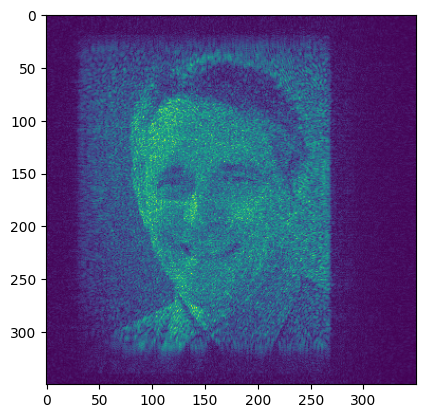

In [323]:
plt.imshow(torch.abs(fwd(phase)).cpu())

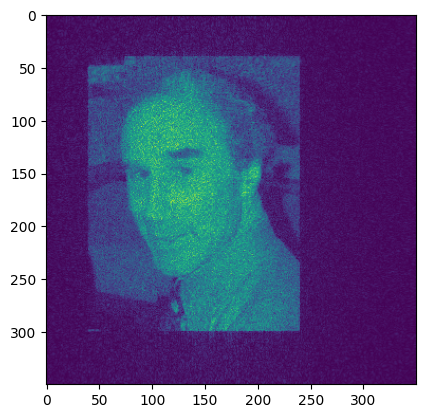

In [324]:
plt.imshow(torch.abs(fwd(fwd(phase))).cpu())

## 2

Text(0, 0.5, 'mean squared error')

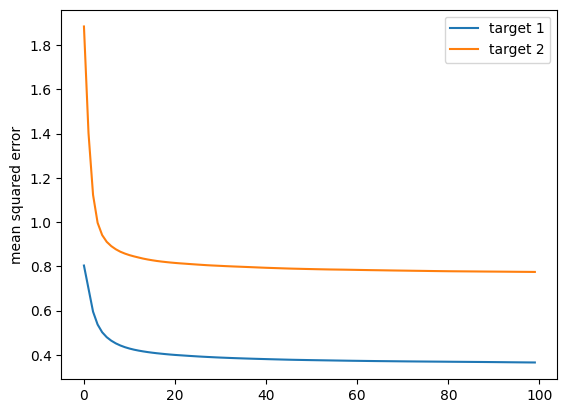

In [325]:
plt.plot(target1_log, label="target 1")
plt.plot(target2_log, label="target 2")
plt.legend()
plt.ylabel("mean squared error")

# 3

Text(0, 0.5, 'SSIM')

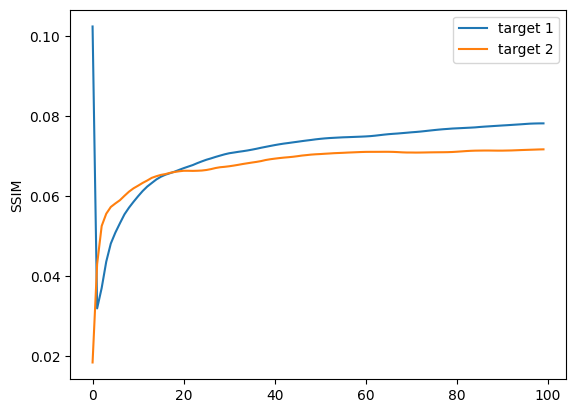

In [326]:
plt.plot(target1_log_ssim, label="target 1")
plt.plot(target2_log_ssim, label="target 2")
plt.legend()
plt.ylabel("SSIM")